# Demonstration - Dataset Dictionary Learning

## Further Information

### Context

In this jupyter notebook, we demonstrate how we can train a dictionary of empirical distributions for domain adaptation. If you find this code useful in our work, please consider citing us,

```
@article{montesuma2023multi,
  title={Multi-Source Domain Adaptation through Dataset Dictionary Learning in Wasserstein Space},
  author={Montesuma, Eduardo Fernandes and Mboula, Fred Ngol{\`e} and Souloumiac, Antoine},
  journal={arXiv preprint arXiv:2307.14953},
  year={2023}
}
```

For more information, [see our pre-print on ArXiV](https://arxiv.org/pdf/2307.14953.pdf).

### Dependencies

The following code relies on [Pytorch](https://pytorch.org/), [PythonOT](https://pythonot.github.io/) and [Scikit-Learn](https://scikit-learn.org/stable/). Please consult the previous links for informations on how to install these libraries.

## Introduction

First, for a distribution $Q$ with i.i.d. samples $\mathbf{x}_{i}^{(Q)} \sim Q$, we can approximate $P$ via,

$$\hat{Q}(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^{n}\delta(\mathbf{x}-\mathbf{x}_{i}^{(Q)})$$

__Problem Description.__ We want to model distributional shift in Multi-Source Domain Adaptation. We pose the problem as follows. Each source domain is a _labeled distribution_, i.e.,

$$\hat{Q}_{\ell}(\mathbf{x},\mathbf{y}) = \frac{1}{n_{\ell}}\sum_{i=1}^{n_{\ell}}\delta \biggr( (\mathbf{x},\mathbf{y})-(\mathbf{x}_{i}^{(Q_{\ell})}, \mathbf{y}_{i}^{(Q_{\ell})})\biggr).$$

The target domain, in its turn, is an _unlabeled distribution_, that is,

$$\hat{Q}_{T}(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^{n}\delta(\mathbf{x}-\mathbf{x}_{i}^{(Q)})$$

__Proposed Solution.__ Our insight is as follows: we want to learn a set of distributions $\mathcal{P} = \{\hat{P}_{k}\}_{k=1}^{K}$, with __free support__, $\{(\mathbf{x}_{i}^{(P_{k})}, \mathbf{y}_{i}^{(P_{k})})\}_{i=1}^{n}$, where $\mathbf{x}_{i}^{(P_{k})}$ denote features and $\mathbf{y}_{i}^{(P_{k})}$ denote (soft-)labels. In this sense, $\hat{P}_{k}$ are parametrized by their support. We want to learn __atoms__ $\mathcal{P}$, and a set of __barycentric coordinates__ $\mathcal{A} = \{\alpha_{\ell}; \sum_{k=1}^{K}\alpha_{\ell,k}=1,\alpha_{\ell,k}\geq 0  \}$, such that,

$$W_{c}(\hat{Q}_{\ell},\mathcal{B}(\alpha_{\ell};\mathcal{P}))$$

where $W_{c}$ is the Wasserstein distance.

In [1]:
import os
import ot
import sys
import time
import torch
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import to_rgba

from tqdm import tqdm
from sklearn.svm import SVC
from torchvision.utils import make_grid

2023-08-21 12:43:56.334564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 12:43:56.416574: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 12:43:56.433319: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-21 12:43:56.736433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [3]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18 
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [4]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [5]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

## Creating Dataset

In [6]:
# Creating datasets
mu = np.array([0, 0])

true_features = []
true_labels = []

separation = 6
angles = [0, 15, 30, 45]
Xs, Ys = [], []
for i in range(n_datasets - 1):
    A = np.random.randn(2, 2)
    cov = .25 * np.dot(A.T, A) + np.eye(2)
    v = np.array([np.cos((np.pi / 180) * angles[i]), np.sin((np.pi / 180) * angles[i])])
    X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
    true_features.append(X)
    true_labels.append(y)
    
    Xs.append(torch.from_numpy(X).float())
    Ys.append(torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float())

In [7]:
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * angles[-1]), np.sin((np.pi / 180) * angles[-1])])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt_tr = torch.from_numpy(X).float()
Yt_tr = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()
true_features.append(X)
true_labels.append(y)

In [8]:
x_minima, x_maxima = [], []
y_minima, y_maxima = [], []

for features in true_features:
    x_minima.append(features[:, 0].min())
    x_maxima.append(features[:, 0].max())
    
    y_minima.append(features[:, 1].min())
    y_maxima.append(features[:, 1].max())
    
xmin, xmax = np.amin(x_minima), np.amax(x_maxima)
ymin, ymax = np.amin(y_minima), np.amax(y_maxima)

print(xmin, xmax, ymin, ymax)

-3.6102320522627234 9.212014518143265 -4.0813975809058896 7.384115192902344


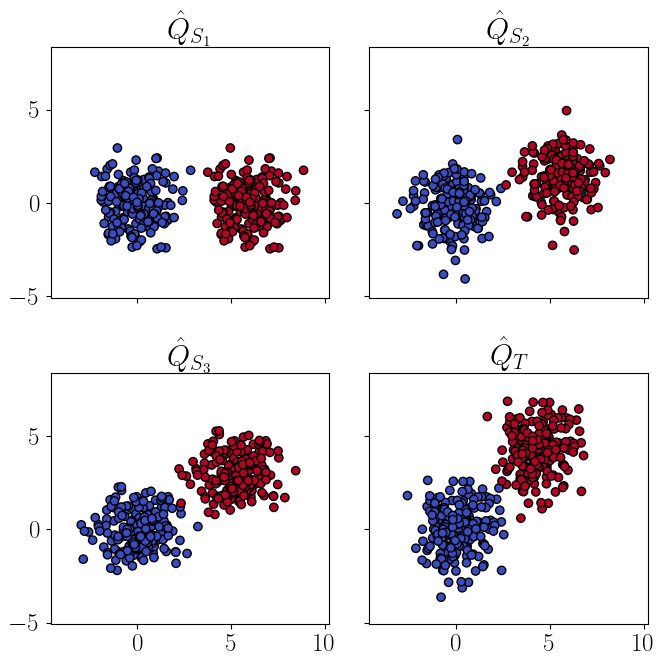

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
        
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

ax = axes.flatten()[-1]
Xi = true_features[-1]
Yi = true_labels[-1]
# ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c='gray', edgecolor='k')
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

In [10]:
datasets = [(Xsk, Ysk) for Xsk, Ysk in zip(Xs, Ys)] + [(Xt_tr, None)]

## Wasserstein Barycenters

Here we implement Algorithm 1 of our paper, whose pseudo-code is as follows,

![Labeled Wasserstein Barycenter](./algorithm1.png)

In [11]:
def wasserstein_barycenter(XP,
                           YP=None,
                           XB=None,
                           YB=None,
                           weights=None,
                           n_samples=None,
                           n_iter_max=10,
                           tol=1e-9,
                           verbose=False,
                           inner_verbose=False,
                           propagate_labels=False,
                           penalize_labels=False):
    if n_samples is None and XB is None:
        # If number of points is not provided,
        # assume that the support of the barycenter
        # has sum(nsi) where si is the i-th source
        # domain.
        n_samples = int(np.sum([len(XPk) for XPk in XP]))
    
    if YP is None:
        if propagate_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                             " for 'propagate_labels' = True"))
        if penalize_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                              " for 'penalize_labels' = True"))
    else:
        n_classes = YP[0].shape[1]
    dtype = XP[0].dtype
    device = XP[0].device

    if weights is None:
        weights = unif(len(XP), device=device, dtype=dtype)

    it = 0
    comp_start = time.time()

    # Initializes Features
    if XB is None:
        XB = torch.randn(n_samples, XP[0].shape[1])

    # Initializes Labels
    if YB is None:
        yB = torch.from_numpy(
            np.random.randint(low=0,
                              high=n_classes,
                              size=n_samples)).long()
        YB = torch.nn.functional.one_hot(
            yB, num_classes=n_classes).float()

    # Displacement of points in the support
    delta = tol + 1
    last_loss = np.inf
    # Create uniform weights
    u_P = [torch.ones(len(XPk), device=device) / len(XPk) for XPk in XP]
    u_B = torch.ones(len(XB), device=device) / len(XB)

    while (delta > tol and it < n_iter_max):
        # NOTE: Here we solve the barycenter problem without calculating
        # gradients at each iteration, as per the envelope theorem, we
        # only need to compute gradients at optimality.
        with torch.no_grad():
            C, ot_plans = [], []

            for k in range(len(XP)):
                C_k = torch.cdist(XP[k], XB, p=2) ** 2
                if penalize_labels:
                    C_k += C_k.detach().max() * torch.cdist(YP[k], YB, p=2) ** 2
                plan_k = ot.emd(u_P[k], u_B, C_k)
                C.append(C_k)
                ot_plans.append(plan_k.to(dtype))
            XB = sum([
                w_k * n_samples * torch.mm(plan_k.T, XP_k)
                for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
            ])
            if propagate_labels:
                YB = sum([
                    w_k * n_samples * torch.mm(plan_k.T, YP_k)
                    for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
                ])
            loss = sum([
                torch.sum(C_k * plan_k) for C_k, plan_k in zip(C, ot_plans)
            ])
            delta = torch.norm(loss - last_loss) / n_samples
            last_loss = loss

            it += 1
    # Re-evaluate the support at optimality for calculating the gradients
    # NOTE: now we define the support while holding its gradients w.r.t. the
    # weight vector and eventually the support.
    XB = sum([
        w_k * n_samples * torch.mm(plan_k.T, XP_k)
        for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
    ])
    if propagate_labels:
        YB = sum([
            w_k * n_samples * torch.mm(plan_k.T, YP_k)
            for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
        ])
        return XB, YB
    return XB

## Dictionary Learning

In this section we train our dictionary using labeled source domain data, and unlabeled target domain data. The pseudo-code for DaDiL is as follows,

![DaDiL Learning Loop](./algorithm2.png)

### Hyper Parameters

In [12]:
lr = 1e-1
n_iter_max = 20
n_samples = 1024
batch_size = 128
n_components = 3
batches_per_it = n_samples // batch_size
spc = n_samples // n_classes
spc_batches = batch_size // n_classes

### Optimization variables definition

First, we need to create the variables that we will optimize. In our paper, we parametrize empirical distributions through their support, i.e.,

$$\hat{P}_{k}(\mathbf{x},\mathbf{y}) = \dfrac{1}{n}\sum_{i=1}^{n}\delta((\mathbf{x}, \mathbf{y})-(\mathbf{x}_{i}^{(P_{k})}, \mathbf{y}_{i}^{(P_{k})}))$$

where $\mathbf{x} \in \mathbb{R}^{d}$ is a feature vector, and $\mathbf{y} \in \Delta_{n_{c}}$ is a vector containing the probability of a sample belonging to class $c=1,\cdots,n_{c}$.

In [13]:
XP = torch.nn.ParameterList([
    torch.nn.parameter.Parameter(data=torch.randn(n_samples, 2), requires_grad=True)
    for _ in range(n_components)
])

In [14]:
YP_init = []
for _ in range(n_components):
    ypk = torch.cat(
        [torch.tensor([c] * spc)
         for c in range(n_classes)]
    ).long()
    YPk = torch.nn.functional.one_hot(ypk,
                                      num_classes=n_classes)
    YP_init.append(YPk)

In [15]:
YP = torch.nn.ParameterList([
    torch.nn.parameter.Parameter(data=yp.float(),
                                 requires_grad=True)
    for yp in YP_init]
)

In [16]:
A0 = torch.ones(n_datasets, n_components) / 4

A = torch.nn.parameter.Parameter(data=A0, requires_grad=True)

In [17]:
optimizer = torch.optim.Adam([*XP, *YP, A], lr=lr)

### Loss Definition

Now, let us analyze the loss function of DaDiL,

If $\hat{Q}_{\ell}$ is labeled:

$$\mathcal{L}(\hat{Q}_{\ell},\hat{B}_{\ell}) = W_{c}(\hat{Q}_{\ell},\hat{B}_{\ell})$$

otherwise,

$$W_{2}(\hat{Q}_{\ell},\hat{B}_{\ell}).$$

Naturally, the source domains are labeled so the first option is used. The last option is used on the target domain. If labels are available, we compute a __supervised__ Wasserstein distance, which ground-cost,

$$C_{ij} = \lVert \mathbf{x}_{i}^{(P)} - \mathbf{x}_{j}^{(Q)} \rVert_{2}^{2} + \beta\lVert \mathbf{y}_{i}^{(P)} - \mathbf{y}_{j}^{(Q)} \rVert_{2}^{2}$$

otherwise, we calculate a standard $W_{2}$ between $P$ and $Q$. This is defined below,

In [18]:
class JointWassersteinDistance(torch.nn.Module):
    def __init__(self):
        super(JointWassersteinDistance, self).__init__()

    def forward(self, XQ, YQ, XP, YP, index=None):
        a = torch.ones(XP.shape[0], device=XP.device) / XP.shape[0]
        b = torch.ones(XQ.shape[0], device=XQ.device) / XQ.shape[0]
        CX = torch.cdist(XP, XQ, p=2) ** 2

        if YP is not None and YQ is not None:
            CY = torch.cdist(YP, YQ, p=2) ** 2
        else:
            CY = torch.zeros_like(CX)

        label_weight = CX.detach().max()

        C = CX + label_weight * CY
        with torch.no_grad():
            # NOTE: We DO NOT backpropagate through
            #       the OT plan.
            plan = ot.emd(a, b, C)
        return torch.sum(C * plan)

In [19]:
criterion = JointWassersteinDistance()

### Learning Loop

In [20]:
fit_history = {
    'weights': [],
    'loss': [],
    'atoms_features': [],
    'atoms_labels': []
}

In [21]:
for it in range(n_iter_max):
    pbar = tqdm(range(batches_per_it))
    avg_it_loss = 0.0
    for _ in pbar:
        optimizer.zero_grad()
        
        loss = 0.0
        for l, ((XQl, YQl), al) in enumerate(zip(datasets, A)):
            # Samples a minibatch from XQl
            if YQl is None:
                indices = np.random.choice(np.arange(len(XQl)), size=batch_size)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = None
            else:
                yQl = YQl.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yQl == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = YQl[indices]
                
            # Samples a minibatch from each XP
            minibatch_XP = []
            minibatch_YP = []
            for XPk, YPk in zip(XP, YP):
                yPk = YPk.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yPk == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                
                minibatch_XP.append(XPk[indices])
                minibatch_YP.append(YPk[indices])
                
            # Calculates a Wasserstein Barycenter
            minibatch_XBl, minibatch_YBl = wasserstein_barycenter(
                XP=minibatch_XP,
                YP=minibatch_YP,
                XB=None,
                YB=None,
                weights=al,
                n_samples=batch_size,
                n_iter_max=10,
                tol=1e-9,
                verbose=False,
                inner_verbose=False,
                propagate_labels=True,
                penalize_labels=True)
            
            loss_l = criterion(minibatch_XQl,
                               minibatch_YQl,
                               minibatch_XBl,
                               minibatch_YBl)
            loss += loss_l
        # Backprop
        loss.backward()
        
        # Optimization Step
        optimizer.step()
        
        # project weights back into the simplex
        with torch.no_grad():
            A.data = ot.utils.proj_simplex(A.data.T).T
        
        # Save it for logging
        avg_it_loss += loss.item() / batches_per_it
    # Save vars for plotting
    fit_history['weights'].append(A.data.detach().clone())
    fit_history['loss'].append(avg_it_loss)
    fit_history['atoms_features'].append([XPk.data.detach().clone() for XPk in XP])
    fit_history['atoms_labels'].append([YPk.data.detach().clone() for YPk in YP])
    print(f'It {it} our of {n_iter_max}. Loss: {avg_it_loss}')

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


It 0 our of 20. Loss: 72.07796287536621


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 12.69it/s]


It 1 our of 20. Loss: 63.50951671600342


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.20it/s]


It 2 our of 20. Loss: 54.287697315216064


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.34it/s]


It 3 our of 20. Loss: 44.65734815597534


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.33it/s]


It 4 our of 20. Loss: 36.63576006889343


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.11it/s]


It 5 our of 20. Loss: 31.14963388442993


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.11it/s]


It 6 our of 20. Loss: 26.38237166404724


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.34it/s]


It 7 our of 20. Loss: 22.26392889022827


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.48it/s]


It 8 our of 20. Loss: 18.841757774353027


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.69it/s]


It 9 our of 20. Loss: 15.9355388879776


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.75it/s]


It 10 our of 20. Loss: 14.1005357503891


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.70it/s]


It 11 our of 20. Loss: 12.411087274551392


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.48it/s]


It 12 our of 20. Loss: 11.586272954940796


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.79it/s]


It 13 our of 20. Loss: 10.544886469841003


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.09it/s]


It 14 our of 20. Loss: 9.748296856880188


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.86it/s]


It 15 our of 20. Loss: 8.725835859775543


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 14.77it/s]


It 16 our of 20. Loss: 9.147884368896484


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 14.00it/s]


It 17 our of 20. Loss: 9.49758505821228


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.61it/s]


It 18 our of 20. Loss: 8.986740291118622


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.50it/s]

It 19 our of 20. Loss: 9.420279145240784


Now, let us analyze how the different $\alpha_{\ell}$ evolve throughout training,

In [22]:
whist = torch.stack(fit_history['weights'])

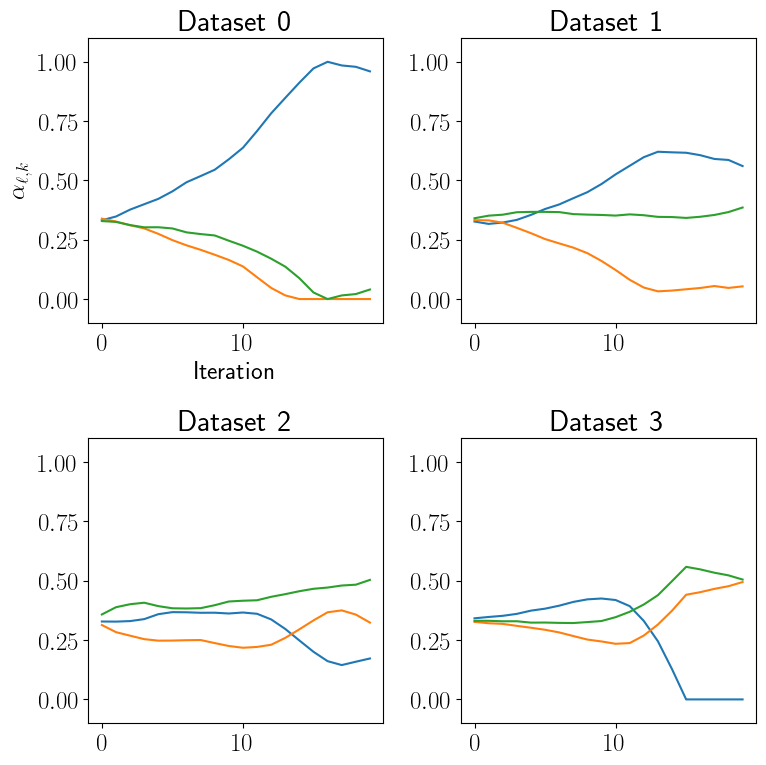

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    for k in range(n_components):
        ax.plot(whist[:, i, k], label='Atom {}'.format(k + 1))
    ax.set_title(f'Dataset {i}')
    ax.set_ylim([-0.1, 1.1])
axes[0, 0].set_ylabel(r'$\alpha_{\ell,k}$')
axes[0, 0].set_xlabel('Iteration')
plt.tight_layout()

Likewise, we are interested in how $\mathbf{X}^{(P_{k})}$ and $\mathbf{Y}^{(P_{k})}$ change throughout the iterations,

In [24]:
XPtrajectory = torch.stack([torch.stack(XPit) for XPit in fit_history['atoms_features']])
YPtrajectory = torch.stack([torch.stack(YPit) for YPit in fit_history['atoms_labels']])

In [25]:
frames = torch.cat([XPtrajectory, YPtrajectory], dim=-1)

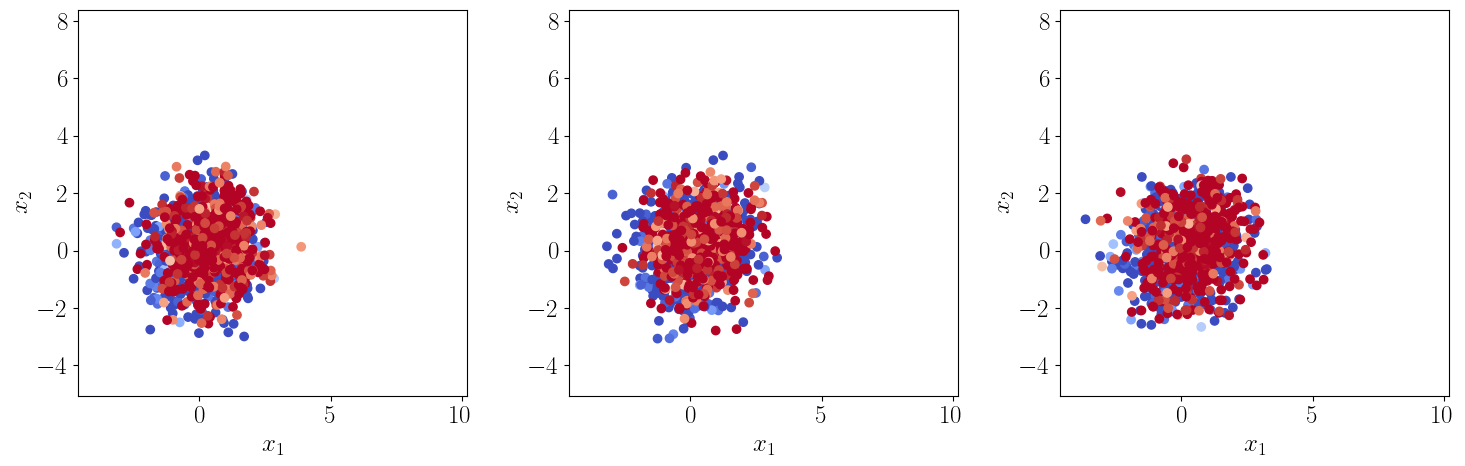

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for k in range(n_components):
    axes[k].scatter(frames[0, k, :, 0],
                    frames[0, k, :, 1],
                    c=frames[0, k, :, -1],
                    cmap='coolwarm',
                    vmin=0.0, vmax=1.0)

def update(frame):
    # clear the axis each frame
    for ax in axes:
        ax.clear()
    
    # replot things
    for k in range(n_components):
        axes[k].scatter(frame[k, :, 0],
                        frame[k, :, 1],
                        c=frame[k, :, -1],
                        cmap='coolwarm',
                        vmin=0,
                        vmax=1)
        axes[k].set_xlim([xmin - 1, xmax + 1])
        axes[k].set_ylim([ymin - 1, ymax + 1])
        axes[k].set_xlabel('$x_{1}$')
        axes[k].set_ylabel('$x_{2}$')
    plt.tight_layout()

anim = FuncAnimation(fig, update, frames=frames, interval=10000)

In [27]:
anim.save('./animation.gif', writer='imagemagick', fps=5)

<Figure size 640x480 with 0 Axes>

Here we visualize the generated animation,

![DaDiL Learning Animation](./animation.gif)

In [28]:
XP = [XPk.detach() for XPk in XP]
YP = [YPk.detach() for YPk in YP]
A = A.detach()

We can visualize the matrix $\mathcal{A}$ through a heatmap,

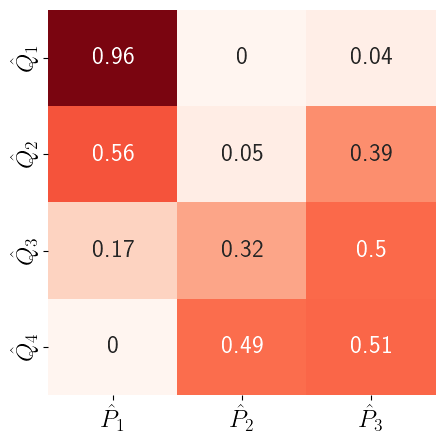

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.heatmap(np.round(A, 2), cmap='Reds', ax=ax, vmin=0.0, vmax=1.0, annot=True, cbar=False)
_ = ax.set_yticks([i + .5 for i in range(len(true_features))],
                  [r"$\hat{Q}_{" + str(i + 1) + "}$" for i in range(len(true_features))])
_ = ax.set_xticks([i + .5 for i in range(len(XP))],
                  [r"$\hat{P}_{" + str(i + 1) + "}$" for i in range(len(XP))])

Where the element $\alpha_{\ell,k}$ corresponds to the barycentric coordinate of the $\ell$-th dataset w.r.t. the $k$-th atom. We can also visualize each atom through a scatterplot,

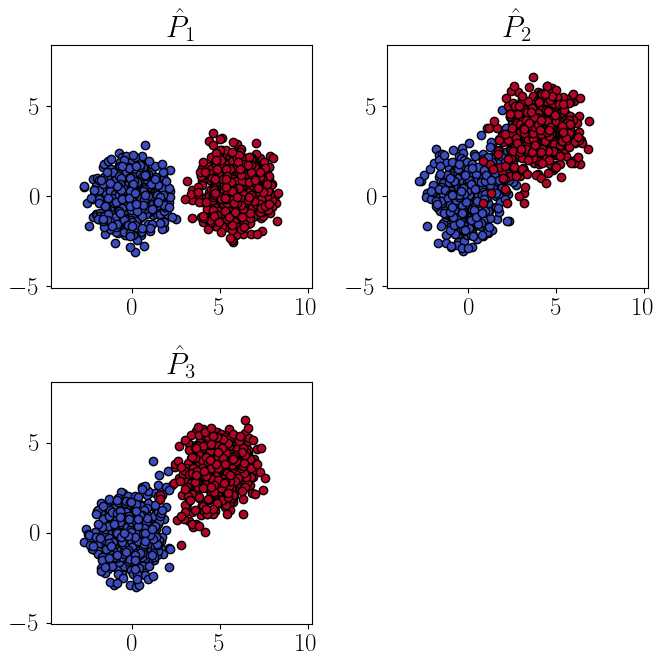

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for k, (ax, X_atom, Y_atom) in enumerate(zip(axes.flatten()[:-1], XP, YP)):
    y_atom = Y_atom.argmax(axis=1)
    ind = np.where(y_atom == 0)[0]
    ax.scatter(X_atom[ind, 0], X_atom[ind, 1], color=c1, edgecolor='k')
    
    ind = np.where(y_atom == 1)[0]
    ax.scatter(X_atom[ind, 0], X_atom[ind, 1], color=c2, edgecolor='k')
    
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])
    
    ax.set_title(r"$\hat{P}_{ " + str(k + 1) + "}$")
axes.flatten()[-1].axis('off')
plt.tight_layout()

we can fit a classifier (in this case, a SVM) on each atom, that is, we find,
$$\hat{h}_{k} = \text{argmin}_{h\in\mathcal{H}}\hat{\mathcal{R}}_{P_{k}}(h)$$

In [31]:
classifiers = []
for X_atom, Y_atom in zip(XP, YP):
    y_atom = Y_atom.argmax(axis=1)
    
    classifiers.append(SVC(kernel='rbf', probability=True).fit(X_atom, y_atom))

we visualize its predictions on the entire $\mathbb{R}^{2}$ for comparing each obtained classifier. Note that, since classes are separated in each domain, $\mathcal{R}_{P_{k}}$ and $\hat{\mathcal{R}}_{P_{k}}$ are small.

In [32]:
x_range = np.linspace(xmin - 1, xmax + 1, 20)
y_range = np.linspace(ymin - 1, ymax + 1, 20)

x_mesh, y_mesh = np.meshgrid(x_range, y_range)

z_meshes = [
    clf.predict_proba(np.c_[x_mesh.ravel(), y_mesh.ravel()]) for clf in classifiers
]

z_mesh_T = np.einsum('i,inj->nj', A[-1, :], np.stack(z_meshes))[:, 1].reshape(x_mesh.shape)

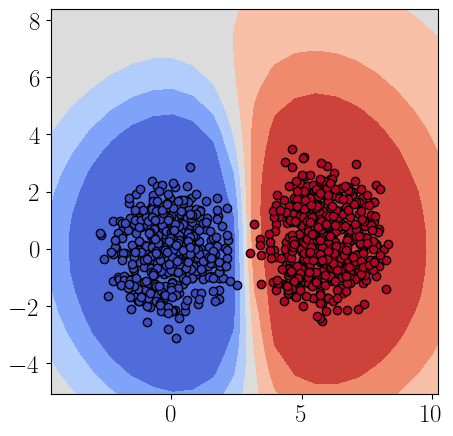

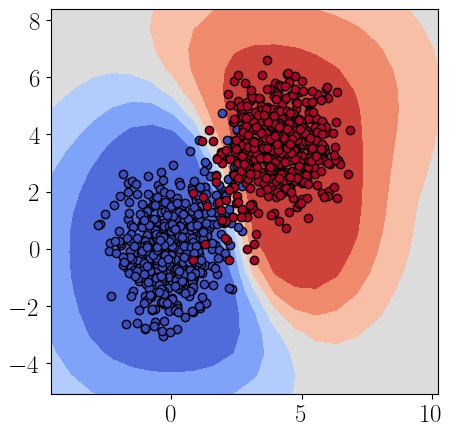

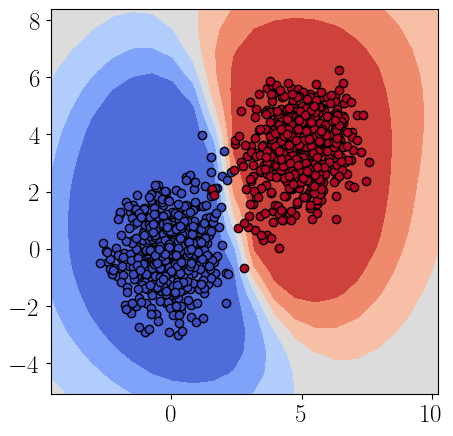

In [33]:
for k, (X_atom, Y_atom, z_mesh) in enumerate(zip(XP, YP, z_meshes)):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    y_atom = Y_atom.argmax(axis=1)
    ind = np.where(y_atom == 0)[0]
    ax.scatter(X_atom[ind, 0], X_atom[ind, 1], color=c1, edgecolor='k', zorder=5)
    
    ind = np.where(y_atom == 1)[0]
    ax.scatter(X_atom[ind, 0], X_atom[ind, 1], color=c2, edgecolor='k', zorder=5)
    
    ax.contourf(x_mesh, y_mesh, z_mesh[:, 1].reshape(x_mesh.shape), cmap=plt.cm.coolwarm, zorder=1)
    
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])
    
    # ax.set_title(r"$\hat{P}_{ " + str(k + 1) + "}$")

Naturally, one may use $\alpha \in \Delta_{K}$ for weighting predictions of atom classifiers. We weight the $\hat{h}_{k}$'s using $\alpha_{T}$, which gives,

$$\hat{h}_{E}(\mathbf{x}^{(Q_{T})}_{j})=\sum_{k=1}^{K}\alpha_{T,k}\hat{h}_{k}(\mathbf{x}_{j}^{(Q_{T})}),$$

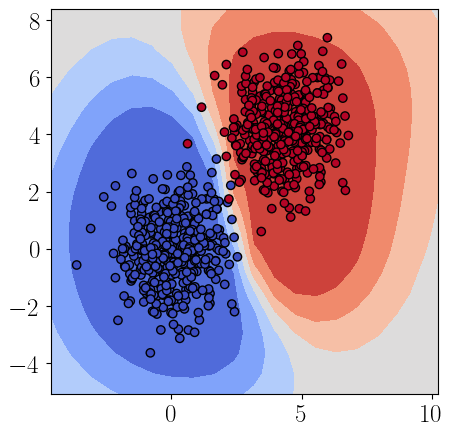

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.contourf(x_mesh, y_mesh, z_mesh_T, cmap=plt.cm.coolwarm, zorder=1)
Xi, yi = true_features[-1], true_labels[-1]
ax.scatter(x=Xi[:, 0], y=Xi[:, 1], c=yi, cmap=plt.cm.coolwarm, edgecolor='k')

Now, let us reconstruct the target domain using a Wasserstein barycenter. This corresponds to iterating,

$$\hat{\mathbf{x}}^{(B_{T})}_{i} = \sum_{k}\alpha_{T,k}T_{\pi^{(k)}}(\mathbf{x}_{i}^{(B_{T})}) = n\sum_{k}\alpha_{T,k}\sum_{j=1}^{n}\pi_{i,j}^{(k)}\mathbf{x}_{j}^{(P_{k})}$$

$$\hat{\mathbf{y}}^{(B_{T})}_{i} = \sum_{k}\alpha_{T,k}T_{\pi^{(k)}}(\mathbf{y}_{i}^{(B_{T})}) = n\sum_{k}\alpha_{T,k}\sum_{j=1}^{n}\pi_{i,j}^{(k)}\mathbf{y}_{j}^{(P_{k})}$$

Until convergence (see Algorithm 1 in the paper).

In [ ]:
Xr, Yr = wasserstein_barycenter(
                XP=XP,
                YP=YP,
                XB=None,
                YB=None,
                weights=A[-1, :],
                n_samples=len(Xt_tr),
                n_iter_max=10,
                tol=1e-9,
                verbose=False,
                inner_verbose=False,
                propagate_labels=True,
                penalize_labels=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

X = true_features[-1]
ax.scatter(x=X[:, 0], y=X[:, 1], color='gray', edgecolor='k', alpha=0.25, label='Original')

X, Y = Xr, Yr
y = Y.argmax(axis=1)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', label='Reconstruction')
ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([xmin - 1, xmax + 1])

_ = ax.set_xticks([-5, 0, 5])
_ = ax.set_yticks([-5, 0, 5])

ax.legend(fontsize=10)

using the labeled samples generated on the target domain, we can find a classifier, defined by,

$$\hat{h}_{R} = \text{argmin}_{h\in\mathcal{H}}\hat{\mathcal{R}}_{B_{T}}(h) = \dfrac{1}{n}\sum_{i=1}^{n}\mathcal{L}(h(\mathbf{x}_{i}^{(B_{T})}),y_{i}^{(B_{T})})$$

In [ ]:
hR = SVC(kernel='rbf', probability=True).fit(Xr, Yr.argmax(dim=1))
hR_mesh = hR.predict_proba(np.c_[x_mesh.ravel(), y_mesh.ravel()])[:, 1].reshape(x_mesh.shape)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.contourf(x_mesh, y_mesh, hR_mesh, cmap=plt.cm.coolwarm, zorder=1)
Xi, yi = true_features[-1], true_labels[-1]
ax.scatter(x=Xi[:, 0], y=Xi[:, 1], c=yi, cmap=plt.cm.coolwarm, edgecolor='k')